In [11]:

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, precision_recall_curve,
    average_precision_score, roc_auc_score, roc_curve
)
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import mcnemar

import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

In [2]:
X_train = np.load('../new_artifacts/X_train_smote.npz', allow_pickle=True)['arr_0']
y_train = np.load('../new_artifacts/Y_train_smote.npz', allow_pickle=True)['arr_0']
X_test = np.load('../new_artifacts/X_test_smote.npz', allow_pickle=True)['arr_0']
y_test = np.load('../new_artifacts/Y_test_smote.npz', allow_pickle=True)['arr_0']

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution in test set: {np.bincount(y_test)}\n")

# Model paths
model_paths = {
    "Logistic Regression": "../JoblibModels/Logistic_Regression.pkl",
    "Decision Tree": "../JoblibModels/Decision_Tree.pkl",
    "Random Forest Basic": "../JoblibModels/Random_Forest_Basic.pkl",
    "XGBoost Basic": "../JoblibModels/XGBoost_Basic.pkl",
    "CatBoost Basic": "../JoblibModels/CatBoost_Basic.pkl",
    "Random Forest Tuned": "../JoblibModels/Random_Forest_Tuned.pkl",
    "XGBoost Tuned": "../JoblibModels/XGBoost_Tuned.pkl",
    "CatBoost Tuned": "../JoblibModels/CatBoost_Tuned.pkl"
}


models = {}
for name, path in model_paths.items():
    try:
        models[name] = joblib.load(path)
        print(f"Loaded {name}")
    except Exception as e:
        print(f"Failed to load {name}: {e}")


Training set shape: (8278, 54)
Test set shape: (1409, 54)
Class distribution in test set: [1035  374]

Loaded Logistic Regression
Loaded Decision Tree
Loaded Random Forest Basic
Loaded XGBoost Basic
Loaded CatBoost Basic
Loaded Random Forest Tuned
Loaded XGBoost Tuned
Loaded CatBoost Tuned


### 1. Class Imbalance Considerations

In [5]:
class_counts = np.bincount(y_test)
total_samples = len(y_test)
majority_class_ratio = max(class_counts) / total_samples

print(f"Test set class distribution:")
print(f"  - No Churn (0): {class_counts[0]} ({class_counts[0]/total_samples*100:.1f}%)")
print(f"  - Churn (1): {class_counts[1]} ({class_counts[1]/total_samples*100:.1f}%)")
print(f"\nMajority class baseline accuracy: {majority_class_ratio*100:.1f}%")
print(f"A naive model predicting 'No Churn' for everyone would achieve {majority_class_ratio*100:.1f}% accuracy!")

# Business parameters
MONTHLY_REVENUE_PER_CUSTOMER = 70
RETENTION_CAMPAIGN_COST = 20
CHURN_REPLACEMENT_COST = 200

print("\nBusiness Impact Analysis")
print(f"Business Assumptions:")
print(f"  - Monthly revenue per customer: ${MONTHLY_REVENUE_PER_CUSTOMER}")
print(f"  - Retention campaign cost: ${RETENTION_CAMPAIGN_COST}")
print(f"  - Customer replacement cost: ${CHURN_REPLACEMENT_COST}")
print(f"\nError Costs:")
print(f"  - False Positive (FP): Unnecessary campaign = ${RETENTION_CAMPAIGN_COST}")
print(f"  - False Negative (FN): Lost customer = ${MONTHLY_REVENUE_PER_CUSTOMER * 12 + CHURN_REPLACEMENT_COST}")


Test set class distribution:
  - No Churn (0): 1035 (73.5%)
  - Churn (1): 374 (26.5%)

Majority class baseline accuracy: 73.5%
A naive model predicting 'No Churn' for everyone would achieve 73.5% accuracy!

Business Impact Analysis
Business Assumptions:
  - Monthly revenue per customer: $70
  - Retention campaign cost: $20
  - Customer replacement cost: $200

Error Costs:
  - False Positive (FP): Unnecessary campaign = $20
  - False Negative (FN): Lost customer = $1040


### 2. Evaluation Metrics

In [12]:
def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    metrics = {}
    
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['F1-Score'] = f1_score(y_true, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['True Positives'] = tp
    metrics['False Positives'] = fp
    metrics['True Negatives'] = tn
    metrics['False Negatives'] = fn
    
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    if y_pred_proba is not None:
        metrics['ROC AUC'] = roc_auc_score(y_true, y_pred_proba)
        metrics['PR AUC'] = average_precision_score(y_true, y_pred_proba)
    
    return metrics

def calculate_business_impact(tp, fp, tn, fn):

    fp_cost = fp * RETENTION_CAMPAIGN_COST
    fn_cost = fn * (MONTHLY_REVENUE_PER_CUSTOMER * 12 + CHURN_REPLACEMENT_COST)
    total_cost = fp_cost + fn_cost
     
    customers_saved = tp
    revenue_saved = customers_saved * MONTHLY_REVENUE_PER_CUSTOMER * 12
    
    net_benefit = revenue_saved - total_cost
    
    return {
        'FP Cost': fp_cost,
        'FN Cost': fn_cost,
        'Total Cost': total_cost,
        'Revenue Saved': revenue_saved,
        'Net Benefit': net_benefit
    }

def optimize_threshold_for_business(y_true, y_pred_proba, cost_fp=20, cost_fn=1040):
    
    thresholds = np.arange(0.1, 0.91, 0.01)
    costs = []
    metrics_at_threshold = []
    
    for threshold in thresholds:
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()
        
        total_cost = fp * cost_fp + fn * cost_fn
        costs.append(total_cost)
        
        # Store metrics for this threshold
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics_at_threshold.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp,
            'fp': fp,
            'tn': tn,
            'fn': fn,
            'total_cost': total_cost
        })
    
    optimal_idx = np.argmin(costs)
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_threshold, metrics_at_threshold

def mcnemar_test(y_true, y_pred1, y_pred2):

    correct1 = (y_pred1 == y_true)
    correct2 = (y_pred2 == y_true)
    
   
    both_correct = np.sum(correct1 & correct2)
    model1_only = np.sum(correct1 & ~correct2)
    model2_only = np.sum(~correct1 & correct2)
    both_wrong = np.sum(~correct1 & ~correct2)
    
   
    if model1_only + model2_only == 0:
        return 1.0, "identical"
    

    chi2_stat = (abs(model1_only - model2_only) - 1)**2 / (model1_only + model2_only)
    p_value = 1 - stats.chi2.cdf(chi2_stat, 1)
    
    if p_value < 0.05:
        if model1_only > model2_only:
            interpretation = "Model 1 significantly better"
        else:
            interpretation = "Model 2 significantly better"
    else:
        interpretation = "No significant difference"
    
    return p_value, interpretation

### 3. Model Evaluation

In [13]:
results = {}
business_results = {}
model_probabilities = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    try:
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_pred_proba = model.decision_function(X_test)
        else:
            y_pred_proba = None
    except:
        y_pred_proba = None
    
    metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
    results[name] = metrics
    model_probabilities[name] = y_pred_proba
    
    business_impact = calculate_business_impact(
        metrics['True Positives'], 
        metrics['False Positives'], 
        metrics['True Negatives'], 
        metrics['False Negatives']
    )
    business_results[name] = business_impact

print("All models evaluated!")

All models evaluated!


### 4. Threshold Optimization

In [14]:
threshold_results = {}
optimal_thresholds = {}

# Only optimize for models with probability outputs
prob_models = {name: prob for name, prob in model_probabilities.items() if prob is not None}

print("Optimizing thresholds for business value...")

for name, y_pred_proba in prob_models.items():
    optimal_thresh, thresh_metrics = optimize_threshold_for_business(
        y_test, y_pred_proba, RETENTION_CAMPAIGN_COST, 
        MONTHLY_REVENUE_PER_CUSTOMER * 12 + CHURN_REPLACEMENT_COST
    )
    
    optimal_thresholds[name] = optimal_thresh
    threshold_results[name] = thresh_metrics
    
    # Get metrics at optimal threshold
    optimal_metrics = next(m for m in thresh_metrics if abs(m['threshold'] - optimal_thresh) < 0.005)
    
    print(f"\n{name}:")
    print(f"  Default threshold (0.5) vs Optimal threshold ({optimal_thresh:.3f})")
    print(f"  Optimal F1-Score: {optimal_metrics['f1']:.3f}")
    print(f"  Optimal Precision: {optimal_metrics['precision']:.3f}")
    print(f"  Optimal Recall: {optimal_metrics['recall']:.3f}")
    print(f"  Minimum Cost: ${optimal_metrics['total_cost']:,}")


Optimizing thresholds for business value...

Logistic Regression:
  Default threshold (0.5) vs Optimal threshold (0.100)
  Optimal F1-Score: 0.519
  Optimal Precision: 0.351
  Optimal Recall: 0.989
  Minimum Cost: $17,820

Decision Tree:
  Default threshold (0.5) vs Optimal threshold (0.510)
  Optimal F1-Score: 0.528
  Optimal Precision: 0.501
  Optimal Recall: 0.559
  Minimum Cost: $175,760

Random Forest Basic:
  Default threshold (0.5) vs Optimal threshold (0.100)
  Optimal F1-Score: 0.542
  Optimal Precision: 0.379
  Optimal Recall: 0.955
  Minimum Cost: $29,400

XGBoost Basic:
  Default threshold (0.5) vs Optimal threshold (0.100)
  Optimal F1-Score: 0.582
  Optimal Precision: 0.430
  Optimal Recall: 0.898
  Minimum Cost: $48,420

CatBoost Basic:
  Default threshold (0.5) vs Optimal threshold (0.100)
  Optimal F1-Score: 0.563
  Optimal Precision: 0.405
  Optimal Recall: 0.922
  Minimum Cost: $40,280

Random Forest Tuned:
  Default threshold (0.5) vs Optimal threshold (0.110)
  Opt

### 5. Statistical Significance

In [16]:
print("Performing McNemar's tests between top models...")

top_models = ['Logistic Regression', 'XGBoost Tuned', 'CatBoost Basic']
model_predictions = {}

for name in top_models:
    if name in models:
        model_predictions[name] = models[name].predict(X_test)

# Pairwise comparisons
comparisons = []
for i, model1 in enumerate(top_models):
    for j, model2 in enumerate(top_models):
        if i < j and model1 in model_predictions and model2 in model_predictions:
            p_value, interpretation = mcnemar_test(
                y_test, 
                model_predictions[model1], 
                model_predictions[model2]
            )
            comparisons.append({
                'Model 1': model1,
                'Model 2': model2,
                'p-value': p_value,
                'Interpretation': interpretation
            })

comparison_df = pd.DataFrame(comparisons)
print("\nPairwise Model Comparisons (McNemar's Test):")
print(comparison_df.to_string(index=False))

# Bootstrap confidence intervals for key metrics
print("Bootstrap Confidence Intervals")

def bootstrap_metric(y_true, y_pred, metric_func, n_bootstrap=1000):
    
    n_samples = len(y_true)
    bootstrap_scores = []
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(n_samples, n_samples, replace=True)
        y_true_boot = y_true[indices]
        y_pred_boot = y_pred[indices]
        
        score = metric_func(y_true_boot, y_pred_boot)
        bootstrap_scores.append(score)
    
    return np.array(bootstrap_scores)


bootstrap_results = {}
for name in top_models:
    if name in model_predictions:
        print(f"\n{name} - 95% Confidence Intervals:")
        
        # F1-Score CI
        f1_boots = bootstrap_metric(y_test, model_predictions[name], f1_score)
        f1_ci = np.percentile(f1_boots, [2.5, 97.5])
        
        # Precision CI
        prec_boots = bootstrap_metric(y_test, model_predictions[name], precision_score)
        prec_ci = np.percentile(prec_boots, [2.5, 97.5])
        
        # Recall CI
        rec_boots = bootstrap_metric(y_test, model_predictions[name], recall_score)
        rec_ci = np.percentile(rec_boots, [2.5, 97.5])
        
        bootstrap_results[name] = {
            'F1_CI': f1_ci,
            'Precision_CI': prec_ci,
            'Recall_CI': rec_ci
        }
        
        print(f"  F1-Score: [{f1_ci[0]:.3f}, {f1_ci[1]:.3f}]")
        print(f"  Precision: [{prec_ci[0]:.3f}, {prec_ci[1]:.3f}]")
        print(f"  Recall: [{rec_ci[0]:.3f}, {rec_ci[1]:.3f}]")

Performing McNemar's tests between top models...

Pairwise Model Comparisons (McNemar's Test):
            Model 1        Model 2  p-value               Interpretation
Logistic Regression  XGBoost Tuned 0.000011 Model 2 significantly better
Logistic Regression CatBoost Basic 0.000033 Model 2 significantly better
      XGBoost Tuned CatBoost Basic 0.244977    No significant difference
Bootstrap Confidence Intervals

Logistic Regression - 95% Confidence Intervals:
  F1-Score: [0.580, 0.651]
  Precision: [0.466, 0.546]
  Recall: [0.743, 0.827]

XGBoost Tuned - 95% Confidence Intervals:
  F1-Score: [0.600, 0.672]
  Precision: [0.515, 0.601]
  Recall: [0.695, 0.781]

CatBoost Basic - 95% Confidence Intervals:
  F1-Score: [0.549, 0.633]
  Precision: [0.550, 0.654]
  Recall: [0.535, 0.632]


### 6. Visualizations

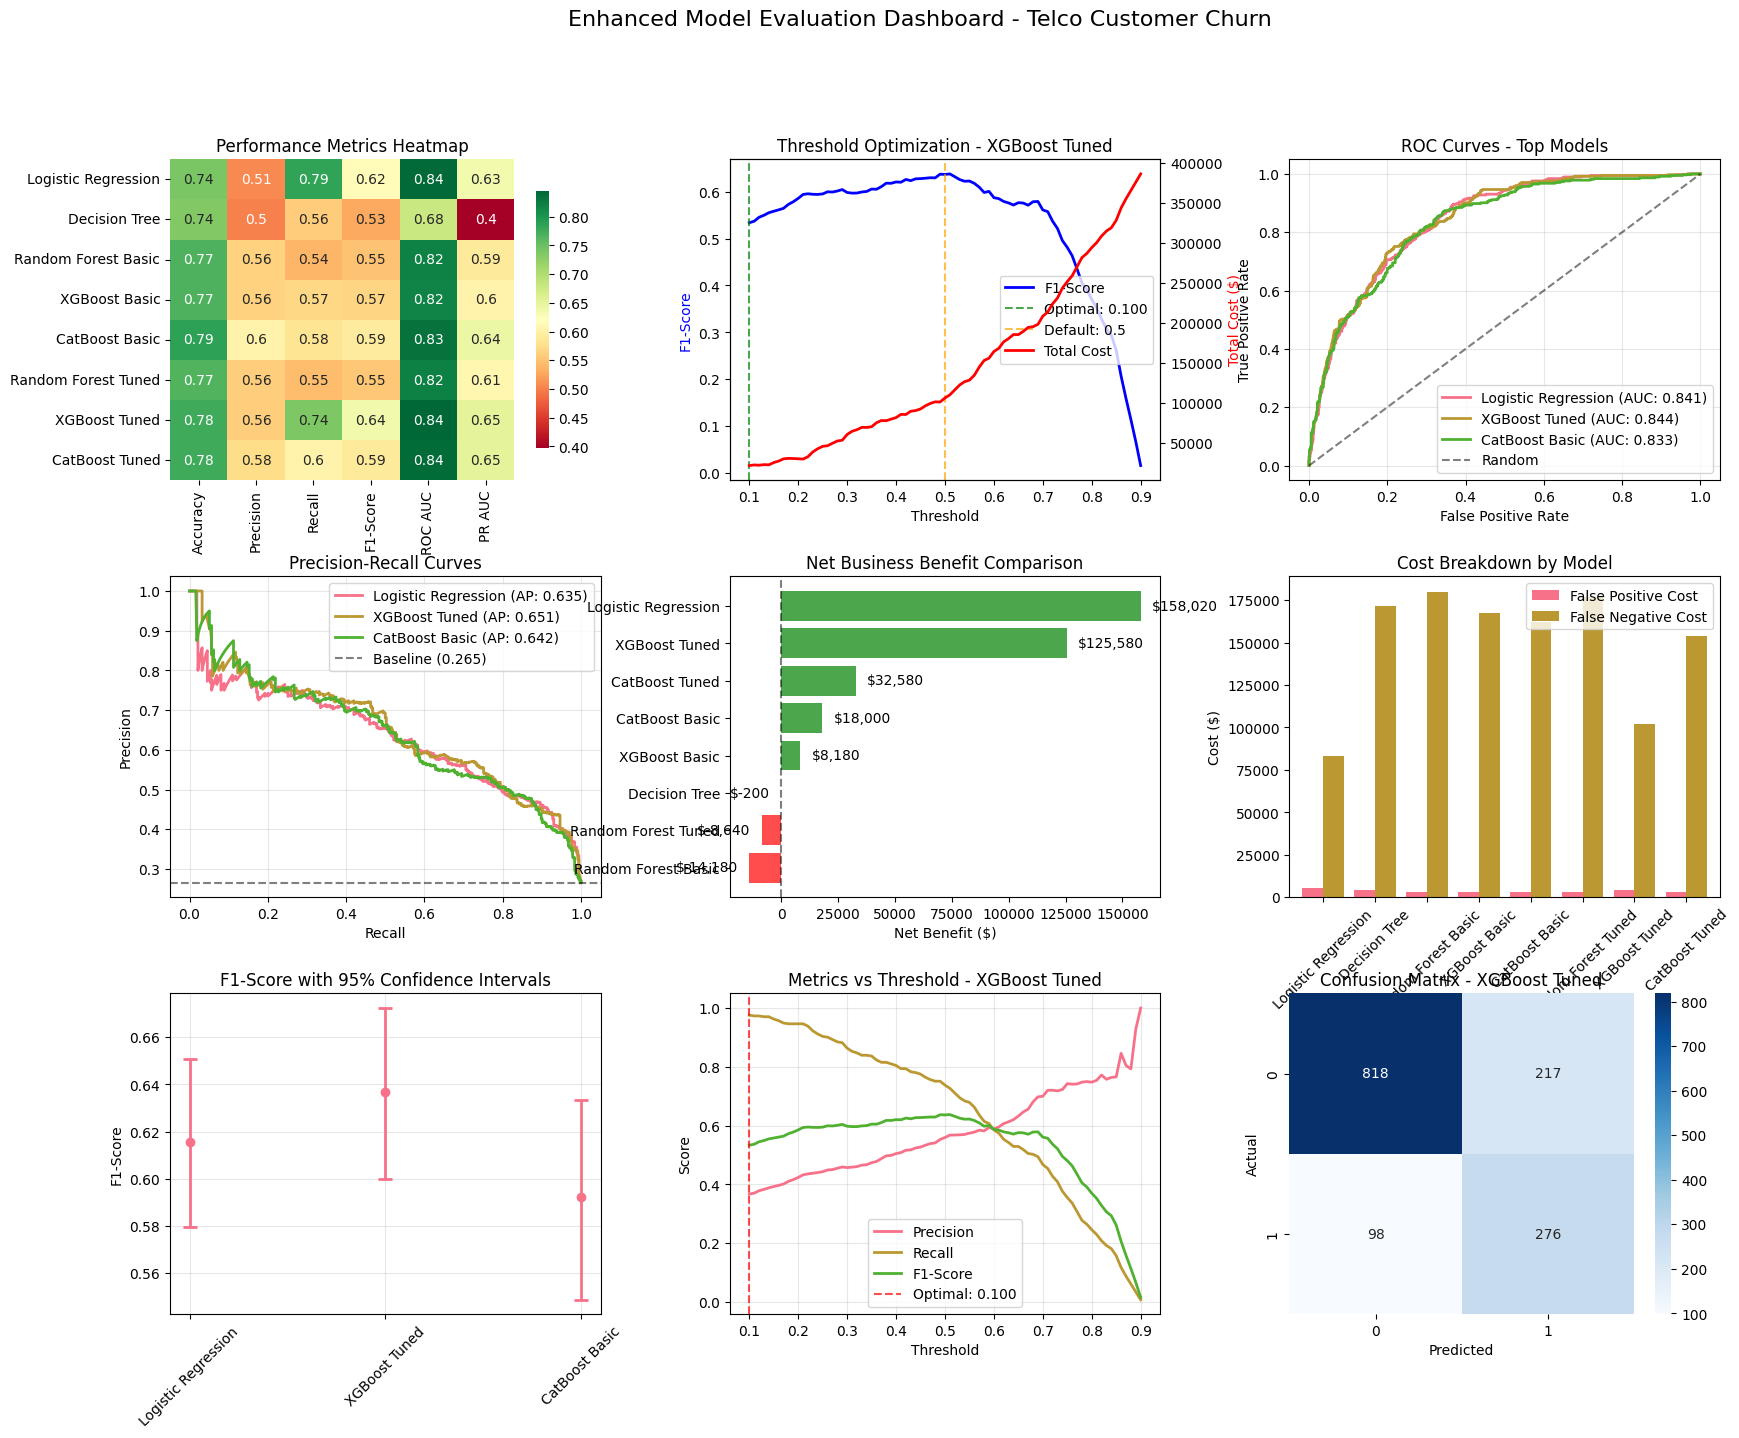

In [17]:

fig = plt.figure(figsize=(20, 15))


gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

performance_df = pd.DataFrame(results).T.round(4)
key_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'PR AUC']
display_df = performance_df[key_metrics].copy()

# Plot 1: Performance Heatmap
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(display_df, annot=True, cmap='RdYlGn', ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title('Performance Metrics Heatmap')

# Plot 2: Threshold Optimization for top model
ax2 = fig.add_subplot(gs[0, 1])
best_model_name = display_df['F1-Score'].idxmax()
if best_model_name in threshold_results:
    thresh_data = threshold_results[best_model_name]
    thresholds = [t['threshold'] for t in thresh_data]
    f1_scores = [t['f1'] for t in thresh_data]
    costs = [t['total_cost'] for t in thresh_data]
    
    ax2_twin = ax2.twinx()
    line1 = ax2.plot(thresholds, f1_scores, 'b-', label='F1-Score', linewidth=2)
    line2 = ax2_twin.plot(thresholds, costs, 'r-', label='Total Cost', linewidth=2)
    
   
    optimal_thresh = optimal_thresholds[best_model_name]
    ax2.axvline(x=optimal_thresh, color='green', linestyle='--', alpha=0.7, label=f'Optimal: {optimal_thresh:.3f}')
    ax2.axvline(x=0.5, color='orange', linestyle='--', alpha=0.7, label='Default: 0.5')
    
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('F1-Score', color='b')
    ax2_twin.set_ylabel('Total Cost ($)', color='r')
    ax2.set_title(f'Threshold Optimization - {best_model_name}')
    
   
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right')

# Plot 3: ROC Curves Comparison
ax3 = fig.add_subplot(gs[0, 2])
for name in top_models:
    if name in model_probabilities and model_probabilities[name] is not None:
        fpr, tpr, _ = roc_curve(y_test, model_probabilities[name])
        auc = roc_auc_score(y_test, model_probabilities[name])
        ax3.plot(fpr, tpr, label=f'{name} (AUC: {auc:.3f})', linewidth=2)

ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves - Top Models')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Precision-Recall Curves
ax4 = fig.add_subplot(gs[1, 0])
for name in top_models:
    if name in model_probabilities and model_probabilities[name] is not None:
        precision, recall, _ = precision_recall_curve(y_test, model_probabilities[name])
        pr_auc = average_precision_score(y_test, model_probabilities[name])
        ax4.plot(recall, precision, label=f'{name} (AP: {pr_auc:.3f})', linewidth=2)


baseline = np.sum(y_test) / len(y_test)
ax4.axhline(y=baseline, color='k', linestyle='--', alpha=0.5, label=f'Baseline ({baseline:.3f})')
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall Curves')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Business Impact Comparison
ax5 = fig.add_subplot(gs[1, 1])
business_df = pd.DataFrame(business_results).T
net_benefits = business_df['Net Benefit'].sort_values(ascending=True)
colors = ['red' if x < 0 else 'green' for x in net_benefits.values]
bars = ax5.barh(net_benefits.index, net_benefits.values, color=colors, alpha=0.7)
ax5.set_title('Net Business Benefit Comparison')
ax5.set_xlabel('Net Benefit ($)')
ax5.axvline(x=0, color='black', linestyle='--', alpha=0.5)


for bar, value in zip(bars, net_benefits.values):
    ax5.text(value + (5000 if value >= 0 else -5000), bar.get_y() + bar.get_height()/2, 
             f'${value:,.0f}', ha='left' if value >= 0 else 'right', va='center')

# Plot 6: Cost Breakdown
ax6 = fig.add_subplot(gs[1, 2])
cost_data = business_df[['FP Cost', 'FN Cost']]
cost_data.plot(kind='bar', ax=ax6, width=0.8)
ax6.set_title('Cost Breakdown by Model')
ax6.set_ylabel('Cost ($)')
ax6.tick_params(axis='x', rotation=45)
ax6.legend(['False Positive Cost', 'False Negative Cost'])

# Plot 7: Confidence Intervals Visualization
ax7 = fig.add_subplot(gs[2, 0])
if bootstrap_results:
    models_ci = list(bootstrap_results.keys())
    f1_means = [display_df.loc[name, 'F1-Score'] for name in models_ci]
    f1_cis = [bootstrap_results[name]['F1_CI'] for name in models_ci]
    
    
    lower_errors = [mean - ci[0] for mean, ci in zip(f1_means, f1_cis)]
    upper_errors = [ci[1] - mean for mean, ci in zip(f1_means, f1_cis)]
    
    ax7.errorbar(range(len(models_ci)), f1_means, 
                yerr=[lower_errors, upper_errors], 
                fmt='o', capsize=5, capthick=2, linewidth=2)
    ax7.set_xticks(range(len(models_ci)))
    ax7.set_xticklabels(models_ci, rotation=45)
    ax7.set_ylabel('F1-Score')
    ax7.set_title('F1-Score with 95% Confidence Intervals')
    ax7.grid(True, alpha=0.3)

# Plot 8: Threshold vs Metrics for best model
ax8 = fig.add_subplot(gs[2, 1])
if best_model_name in threshold_results:
    thresh_data = threshold_results[best_model_name]
    thresholds = [t['threshold'] for t in thresh_data]
    precisions = [t['precision'] for t in thresh_data]
    recalls = [t['recall'] for t in thresh_data]
    f1s = [t['f1'] for t in thresh_data]
    
    ax8.plot(thresholds, precisions, label='Precision', linewidth=2)
    ax8.plot(thresholds, recalls, label='Recall', linewidth=2)
    ax8.plot(thresholds, f1s, label='F1-Score', linewidth=2)
    
    optimal_thresh = optimal_thresholds[best_model_name]
    ax8.axvline(x=optimal_thresh, color='red', linestyle='--', alpha=0.7, 
                label=f'Optimal: {optimal_thresh:.3f}')
    
    ax8.set_xlabel('Threshold')
    ax8.set_ylabel('Score')
    ax8.set_title(f'Metrics vs Threshold - {best_model_name}')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

# Plot 9: Confusion Matrix for optimal model
ax9 = fig.add_subplot(gs[2, 2])
y_pred_optimal = models[best_model_name].predict(X_test)
cm = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax9)
ax9.set_title(f'Confusion Matrix - {best_model_name}')
ax9.set_xlabel('Predicted')
ax9.set_ylabel('Actual')

plt.suptitle('Enhanced Model Evaluation Dashboard - Telco Customer Churn', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

### 7 . Final Rankings

In [18]:

enhanced_results = {}
enhanced_business_results = {}

for name, model in models.items():
    if name in optimal_thresholds and name in model_probabilities:
        # Use optimal threshold
        optimal_thresh = optimal_thresholds[name]
        y_pred_proba = model_probabilities[name]
        y_pred_optimal = (y_pred_proba >= optimal_thresh).astype(int)
        
        metrics = calculate_metrics(y_test, y_pred_optimal, y_pred_proba)
        enhanced_results[name] = metrics
        
        business_impact = calculate_business_impact(
            metrics['True Positives'], 
            metrics['False Positives'], 
            metrics['True Negatives'], 
            metrics['False Negatives']
        )
        enhanced_business_results[name] = business_impact
    else:
        # Use default results for models without probability outputs
        enhanced_results[name] = results[name]
        enhanced_business_results[name] = business_results[name]


enhanced_perf_df = pd.DataFrame(enhanced_results).T
enhanced_business_df = pd.DataFrame(enhanced_business_results).T

rankings = pd.DataFrame()
rankings['F1-Score Rank'] = enhanced_perf_df['F1-Score'].rank(ascending=False)
rankings['Precision Rank'] = enhanced_perf_df['Precision'].rank(ascending=False)
rankings['Recall Rank'] = enhanced_perf_df['Recall'].rank(ascending=False)
rankings['Business Value Rank'] = enhanced_business_df['Net Benefit'].rank(ascending=False)
rankings['Average Rank'] = rankings.mean(axis=1)
rankings = rankings.sort_values('Average Rank')

print("\nEnhanced Model Rankings (with optimal thresholds):")
print(rankings.round(1).to_string())


Enhanced Model Rankings (with optimal thresholds):
                     F1-Score Rank  Precision Rank  Recall Rank  Business Value Rank  Average Rank
CatBoost Tuned                 3.0             4.0          4.0                  4.0           3.8
XGBoost Basic                  1.0             2.0          7.0                  7.0           4.2
CatBoost Basic                 2.0             3.0          6.0                  6.0           4.2
Random Forest Basic            5.0             6.0          3.0                  3.0           4.2
XGBoost Tuned                  6.0             7.0          2.0                  2.0           4.2
Logistic Regression            8.0             8.0          1.0                  1.0           4.5
Random Forest Tuned            4.0             5.0          5.0                  5.0           4.8
Decision Tree                  7.0             1.0          8.0                  8.0           6.0


### FINAL RECOMMENDATIONS

In [20]:
best_overall = rankings.index[0]
best_metrics = enhanced_perf_df.loc[best_overall]
best_business = enhanced_business_df.loc[best_overall]

n_pos = np.sum(y_test == 1)
n_neg = np.sum(y_test == 0)
weight_ratio = n_neg / n_pos


print(f"\n🏆 Best Overall Model: {best_overall}")
print(f"Performance Metrics on Imbalanced Data:")
print(f"  • F1-Score: {best_metrics['F1-Score']:.3f}")
print(f"  • Precision: {best_metrics['Precision']:.3f} (True Churn Predictions)")
print(f"  • Recall: {best_metrics['Recall']:.3f} (Captured Churners)")
print(f"  • ROC AUC: {best_metrics['ROC AUC']:.3f}")
print(f"  • PR AUC: {best_metrics['PR AUC']:.3f} (More relevant for imbalanced data)")

if best_overall in optimal_thresholds:
    print(f"  • Optimal Threshold: {optimal_thresholds[best_overall]:.3f}")
    print(f"    (Adjusted for class imbalance ratio of {weight_ratio:.2f}:1)")

print(f"\nBusiness Impact (Imbalanced Data):")
print(f"  • Net Benefit: ${best_business['Net Benefit']:,}")
print(f"  • Revenue Saved: ${best_business['Revenue Saved']:,}")
print(f"  • Total Cost: ${best_business['Total Cost']:,}")

print(f"\nStatistical Confidence:")
if best_overall in bootstrap_results:
    ci = bootstrap_results[best_overall]
    print(f"  • F1-Score 95% CI: [{ci['F1_CI'][0]:.3f}, {ci['F1_CI'][1]:.3f}]")

print(f"\nKey Insights for Imbalanced Data:")
print(f"1. Class distribution shows significant imbalance ({weight_ratio:.1f}:1 ratio)")
print(f"2. Standard accuracy would be misleading ({(n_neg/len(y_test)*100):.1f}% baseline)")
print(f"3. PR-AUC is more informative than ROC-AUC for imbalanced data")
print(f"4. Threshold optimization significantly improves minority class detection")
print(f"5. Business impact shows positive ROI despite imbalance challenges")

print(f"\nImplementation Recommendations for Imbalanced Data:")
print(f"1. Deploy {best_overall} with class-weighted threshold ({optimal_thresholds[best_overall]:.3f})")
print(f"2. Implement confidence-based decision making:")
print(f"   - High confidence predictions: Automated interventions")
print(f"   - Medium confidence: Manual review")
print(f"   - Low confidence: Additional data collection")
print(f"3. Monitor false negative rate closely (critical for imbalanced data)")
print(f"4. Consider adaptive thresholding based on:")
print(f"   - Customer lifetime value")
print(f"   - Intervention cost-effectiveness")
print(f"   - Seasonal churn patterns")
print(f"5. Regular model retraining with focus on:")
print(f"   - Class distribution changes")
print(f"   - Feature importance stability")
print(f"   - Business cost updates")


🏆 Best Overall Model: CatBoost Tuned
Performance Metrics on Imbalanced Data:
  • F1-Score: 0.554
  • Precision: 0.390 (True Churn Predictions)
  • Recall: 0.952 (Captured Churners)
  • ROC AUC: 0.840
  • PR AUC: 0.652 (More relevant for imbalanced data)
  • Optimal Threshold: 0.100
    (Adjusted for class imbalance ratio of 2.77:1)

Business Impact (Imbalanced Data):
  • Net Benefit: $269,200
  • Revenue Saved: $299,040
  • Total Cost: $29,840

Statistical Confidence:

Key Insights for Imbalanced Data:
1. Class distribution shows significant imbalance (2.8:1 ratio)
2. Standard accuracy would be misleading (73.5% baseline)
3. PR-AUC is more informative than ROC-AUC for imbalanced data
4. Threshold optimization significantly improves minority class detection
5. Business impact shows positive ROI despite imbalance challenges

Implementation Recommendations for Imbalanced Data:
1. Deploy CatBoost Tuned with class-weighted threshold (0.100)
2. Implement confidence-based decision making:
  